In [7]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
    print(cache_dir)
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name}不存在于{DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [8]:
"""使用pandas读入并处理数据"""
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import limutorch as d2l

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( 
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

../data
../data
(1460, 81)
(1459, 80)


In [9]:
"""前四个和最后两个特征，以及相应标签"""
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [10]:
"""在每个样本中，第一个特征是ID，将从数据集中删除"""
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))## 这里的train_data最后一列也没有读取

In [11]:
"""将所有确实的值替换为响应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据"""
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x - x.mean()) / (x.std()))## 将数据集中所有数值全部减去他的均值除以他的方差
all_features[numeric_features] = all_features[numeric_features].fillna(0)## 将数据集中所有nan的元素全部置0

In [12]:
"""处理离散值。使用热编码替换他们"""
all_features = pd.get_dummies(all_features, dummy_na=True)### pd.get_dummies()运算是将某列存在的所有可能性全部变为列数，假设某列内有元素：清华，北大，上交，原有的列数就会增加3列（实际上只增加了两列，原来那一列删除），分别是清华，北大，上交，然后对应输入0或1
all_features.shape

(2919, 331)

In [16]:
"""从pandas格式中提取NumPy格式，并将其转换为张量表示"""
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)
train_features.shape

torch.Size([1460, 331])

In [17]:
"""训练"""
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features, 1))
  return net

我们更关心相对误差$\frac {y-\hat y}{y}$,解决这个问题的一种方法就是使用价格的对数来衡量差异

In [18]:
def log_rmse(net, features, labels):
  clipped_preds = torch.clamp(net(features), 1, float('inf'))## torch.clamp是将net(features)的输出压缩到[1, float('inf')]之间
  rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
  return rmse.item()

In [19]:
"""训练使用Adam优化器"""
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X), y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

In [20]:
"""K折交叉验证"""
def get_K_fold_data(k, i, X, y):
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j * fold_size, (j+1) * fold_size)
    X_part, y_part = X[idx,:], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid

In [22]:
"""返回训练和验证误差的平均值"""
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, 
           batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_K_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                               weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls], 
           xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs+1],
           legend=['train', 'valid'], yscale='log')
    print(f'fold{i+1}, train log rmse {float(train_ls[-1]):f},'
       f'valid log rmse {float(valid_ls[-1]):f}')
  return train_l_sum / k, valid_l_sum / k

fold1, train log rmse 0.148557valid log rmse 0.147388
fold2, train log rmse 0.145063valid log rmse 0.164359
fold3, train log rmse 0.142802valid log rmse 0.147799
fold4, train log rmse 0.148848valid log rmse 0.148414
fold5, train log rmse 0.142310valid log rmse 0.173741
5-折验证：平均训练log rmse: 0.145516,平均验证log rmse: 0.156340


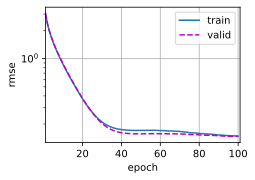

In [25]:
"""模型选择"""
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, 
              lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse: {float(train_l):f},'
   f'平均验证log rmse: {float(valid_l):f}')

train log rmse 0.140128


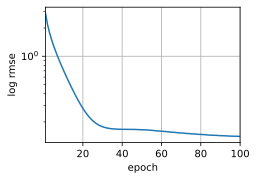

In [29]:
"""提交Kaggle预测"""
def train_and_pred(train_features, test_features, train_labels, test_data, 
          num_epochs, lr, weight_decay, batch_size):
  net = get_net()
  train_ls, _ = train(net, train_features, train_labels, None, None,
              num_epochs, lr, weight_decay, batch_size)
  d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch', ylabel='log rmse',
       xlim=[1, num_epochs], yscale='log')
  print(f'train log rmse {float(train_ls[-1]):f}')
  pred = net(test_features).detach().numpy()
  test_data['SalePrice'] = pd.Series(pred.reshape(1, -1)[0])
  submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
  submission.to_csv('submission.csv',index=False)

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs,
        lr, weight_decay, batch_size)